In [1]:
import numpy as np
import numpy.random as rng
import torch 
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
from model import MLP_variant
from simulators import Generator_doubleNormal_lr
from simulators import Generator_doubleNormal
import matplotlib.pyplot as plt 
import time 
from scipy.stats import norm
from scipy.optimize import fsolve
from tqdm import tqdm  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\97255\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def predict(model, Y): 
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

# Linear Regression

In [35]:
rho = 0.6
N = 200
p = 200 
rng.seed(0)
Sigma = np.ones((p, p)) * rho
Sigma = Sigma + np.diag(np.ones(p) * (1-rho))
X = rng.multivariate_normal(np.zeros(p), Sigma, N)
X = X - np.mean(X, axis=0)
X = X * np.sqrt(N / np.sum(X**2, axis=0))
np.save("./data/X_rho06_N200_p200.npy", X)

In [37]:
def normalize_constant_est(generator, n=100000, seed=0):
    gamma_train, beta_train, Y_train = generator.generate_samples(n)
    mean = Y_train.mean(0)
    std = Y_train.std(0)
    return mean, std 

In [38]:
from simulators import Generator_doubleNormal_lr
theta = 0.05
sigma0 = 0.1
sigma1 = 5
generator = Generator_doubleNormal_lr(X, theta, sigma0, sigma1)
mean, std = normalize_constant_est(generator)

In [39]:
np.save("./data/mean_rho06_N200_p200.npy", mean)
np.save("./data/std_rho06_N200_p200.npy", std)

In [152]:
X = np.load("./data/X_rho0_N50_p50.npy")

In [36]:
np.corrcoef(X.T)

array([[1.        , 0.67746764, 0.67555132, ..., 0.7072725 , 0.65236613,
        0.58739227],
       [0.67746764, 1.        , 0.6505906 , ..., 0.59454596, 0.57687989,
        0.58995019],
       [0.67555132, 0.6505906 , 1.        , ..., 0.57916918, 0.57925644,
        0.60159322],
       ...,
       [0.7072725 , 0.59454596, 0.57916918, ..., 1.        , 0.55744715,
        0.58691861],
       [0.65236613, 0.57687989, 0.57925644, ..., 0.55744715, 1.        ,
        0.60033989],
       [0.58739227, 0.58995019, 0.60159322, ..., 0.58691861, 0.60033989,
        1.        ]])

In [3]:
X = np.load("./results/linear regression/X_p200_q975_exp0.npy")
X

array([[ 0.11096124, -1.20658915,  1.38876269, ..., -0.45960709,
         1.27803992, -0.6989734 ],
       [ 1.717001  ,  0.49574854, -0.0927022 , ..., -0.04049755,
         1.19841457, -2.01410873],
       [-0.21892588,  0.21185206,  1.88542418, ..., -0.1903413 ,
         0.96657823,  1.15744877],
       ...,
       [ 0.79000073,  1.21013674,  0.34427403, ...,  1.03806171,
        -1.07070599,  0.94925301],
       [ 0.01806298,  0.35198879,  0.92940414, ...,  0.39781412,
         0.16572629,  0.40858087],
       [ 0.66956391,  0.57823322,  1.72890534, ..., -0.63743735,
        -2.13014212, -0.89233741]])

In [154]:
md_q025 = MLP_variant(50, 50, [1024, 1024], 'leakyrelu').to(device)
md_q025.load_state_dict(torch.load("./model/linear regression/p50_q25_exp0.pt"))
md_q975 = MLP_variant(50, 50, [1024, 1024], 'leakyrelu').to(device)
md_q975.load_state_dict(torch.load("./model/linear regression/p50_q975_exp0.pt"))

<All keys matched successfully>

In [155]:
mean = np.load("./results/linear regression/mean_p50_q25_exp0.npy")
std = np.load("./results/linear regression/std_p50_q25_exp0.npy")

In [156]:
p = 50

In [157]:
theta = 0.05 
sigma0 = 0.1 
sigma1 = 5 
generator = Generator_doubleNormal_lr(X, theta, sigma0, sigma1)
rng.seed(1) 
gamma_test, beta_test, Y_test = generator.generate_samples(10000) 
Y_test_normalized = (Y_test - mean) / std 

In [158]:
np.save("./data/beta_test_p50_rho0.npy", beta_test)
np.save("./data/Y_test_p50_rho0.npy", Y_test)

In [159]:
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)

Cross quantile

In [160]:
np.sum(pred_q025>pred_q975)/(p*10000)

2e-06

Cover rate

In [161]:
np.sum((pred_q025<=beta_test)&(beta_test<=pred_q975))/(p*10000)

0.949988

Mean CI width

In [162]:
np.mean(np.maximum(pred_q975-pred_q025, 0))

0.37556863

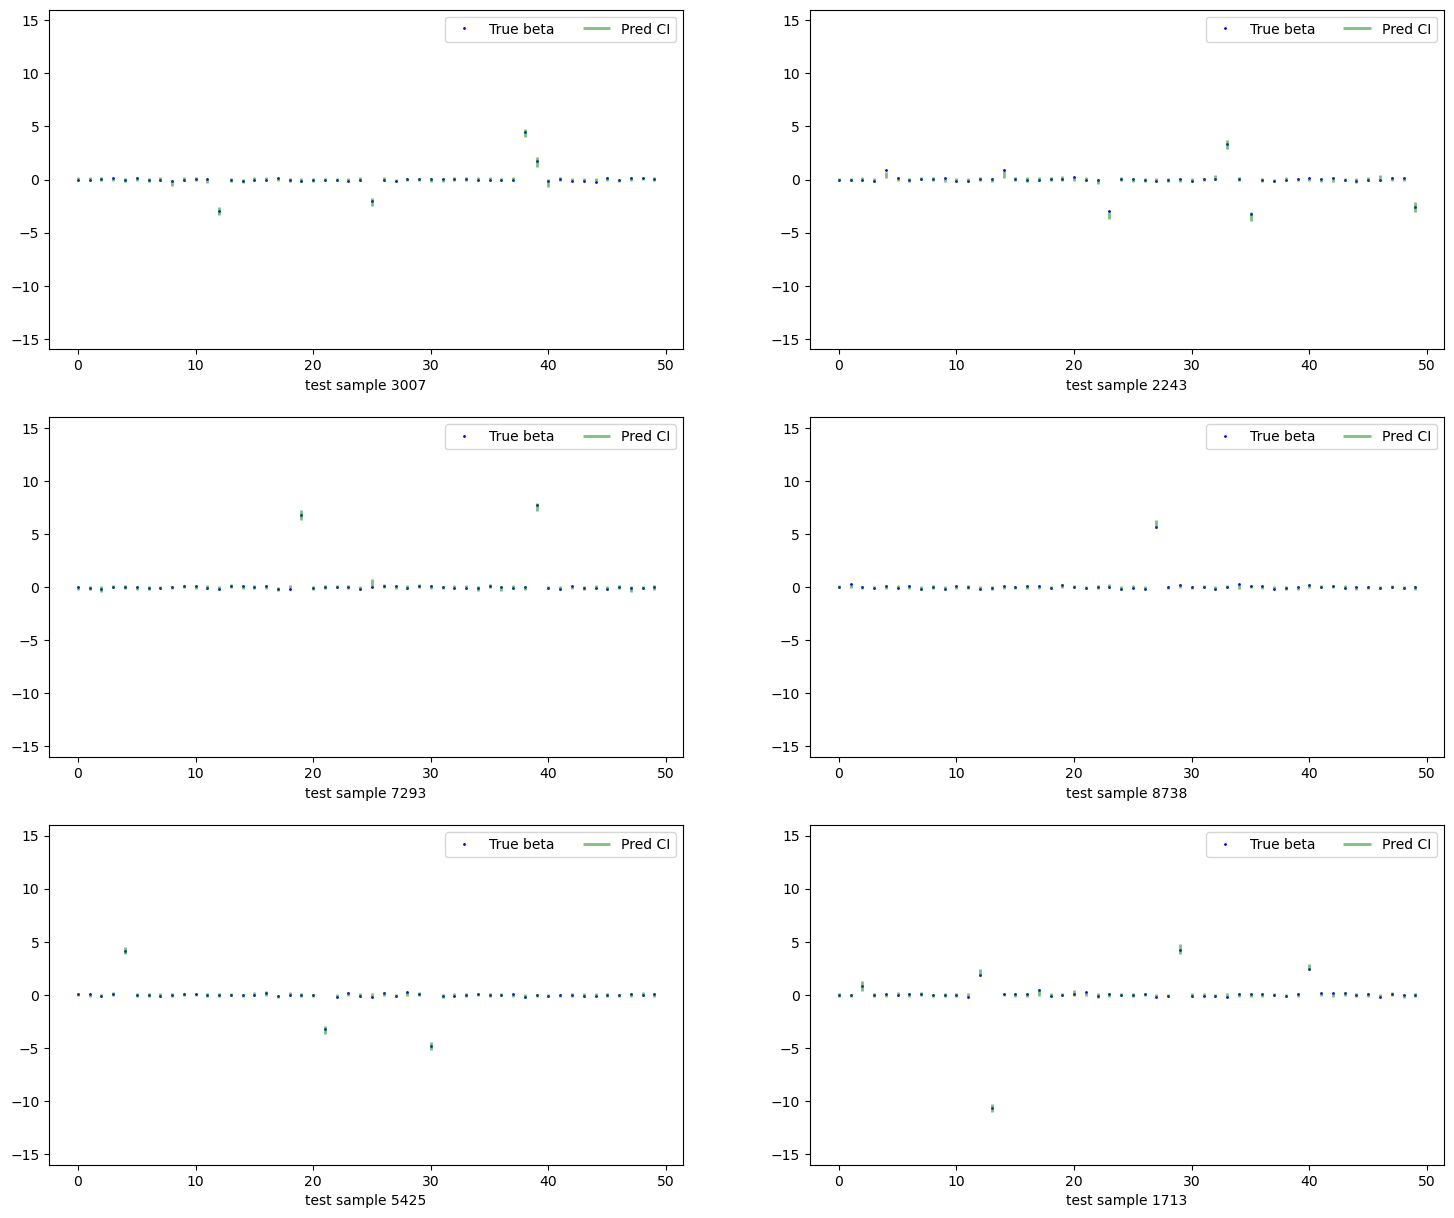

In [69]:
subset = np.where(np.abs(beta_test)>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), beta_test[idx], '.b', ms=2)
    plt.vlines(np.arange(p), pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True beta', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
    plt.xlabel(f'test sample {idx}')
plt.savefig('C:/Users/97255/OneDrive/Desktop/Bayesian Inference using DL/LM_exp0_figures/test_10.png')
plt.show()

In [192]:
test_id = 9
ssvs_CI = np.load(f"./data/ssvs_rho0_test{test_id}.npy")
bbssl_CI = np.load(f"./data/bbssl_rho0_test{test_id}.npy")
dblasso_CI = np.load(f"./data/dblasso_rho0_test{test_id}.npy")

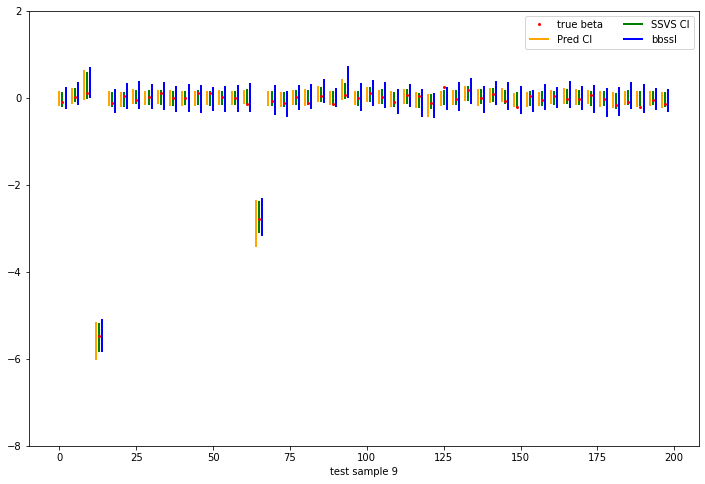

In [194]:
plt.figure(figsize=(12, 8))
plt.vlines(np.arange(p)*4, pred_q025[test_id], pred_q975[test_id], color='orange', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+1, ssvs_CI[:,0], ssvs_CI[:,1], color='green', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+2, bbssl_CI[:,0], bbssl_CI[:,1], color='blue', alpha=1, lw=2)
plt.plot(np.arange(p)*4+1, beta_test[test_id], '.r', ms=4)
plt.legend(["true beta", 'Pred CI', 'SSVS CI', 'bbssl'], ncol=2)
plt.ylim(-8, 2)
plt.xlabel(f'test sample {test_id}')
plt.savefig(f"C:/Users/Alienware/OneDrive/Desktop/Bayesian Inference using DL/vs_rho0_figures/test{test_id}")
plt.show()

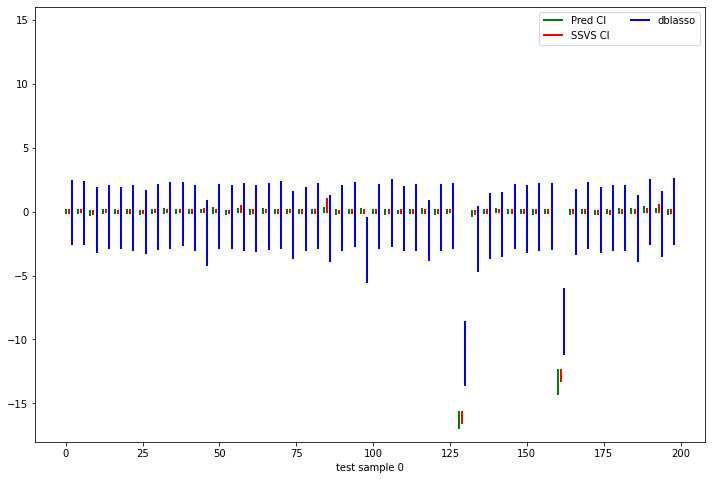

In [52]:
# plt.plot(range(p), beta_test[0], '.b', ms=2)
plt.figure(figsize=(12, 8))
plt.vlines(np.arange(p)*4, pred_q025[0], pred_q975[0], color='green', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+1, ssvs_CI[:,0], ssvs_CI[:,1], color='red', alpha=1, lw=2)
plt.vlines(np.arange(p)*4+2, dblasso_CI[:,0], dblasso_CI[:,1], color='blue', alpha=1, lw=2)
plt.legend(['Pred CI', 'SSVS CI', 'dblasso'], ncol=2)
plt.ylim(-18,16)
plt.xlabel(f'test sample {0}')
plt.show()

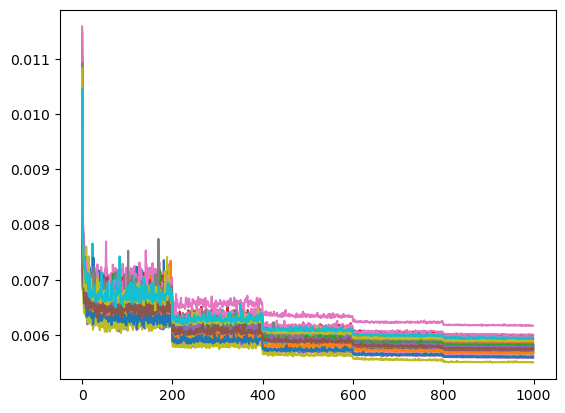

In [4]:
coordinate_loss = np.load("./results/linear regression/coordinate_loss_p50_q25_exp0.npy") 
plt.plot(coordinate_loss)
plt.show()

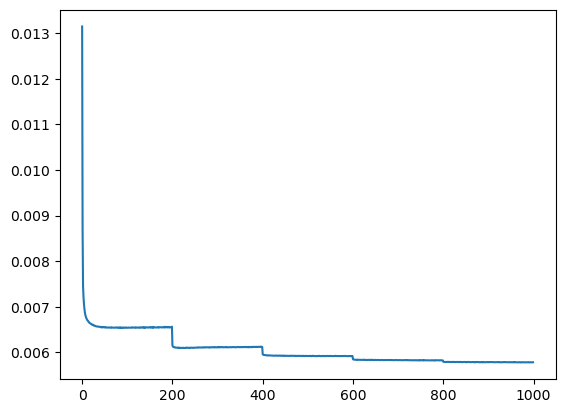

In [5]:
train_loss = np.load("./results/linear regression/train_losses_p50_q25_exp0.npy")
plt.plot(train_loss)
plt.show()

In [28]:
rho = 0
N = 50
p = 50
rng.seed(0)
Sigma = np.ones((p, p)) * rho
Sigma = Sigma + np.diag(np.ones(p) * (1-rho))
X = rng.multivariate_normal(np.zeros(p), Sigma, N)
X = X - np.mean(X, axis=0)
X = X * np.sqrt(N / np.sum(X**2, axis=0))
np.save("./data/X_rho0_N50_p50.npy", X)

# p=50

In [20]:
train_losses = np.load('./results/train_losses_p50_q25_exp0.npy')
val_losses = np.load('./results/val_losses_p50_q25_exp0.npy')

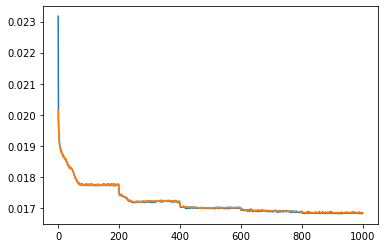

In [21]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [22]:
coordinate_loss = np.load("./results/coordinate_loss_p50_q25_exp0.npy")

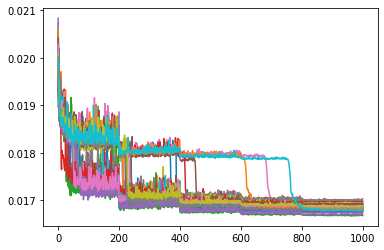

In [23]:
plt.plot(coordinate_loss)
plt.show()

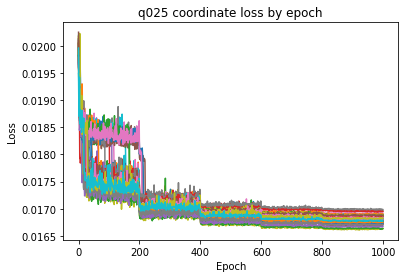

In [7]:
coordinate_loss_q025 = np.load("./results/coordinate_loss_p50_q25_exp5.npy")
plt.plot(coordinate_loss_q025)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q025 coordinate loss by epoch")
plt.show()

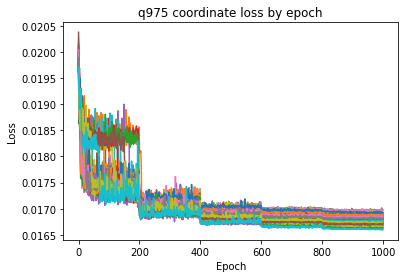

In [8]:
coordinate_loss_q975 = np.load("./results/coordinate_loss_p50_q975_exp5.npy")
plt.plot(coordinate_loss_q975)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q975 coordinate loss by epoch")
plt.show()

In [9]:
mean = np.load("./results/mean_p50_q25_exp5.npy")
mean

array([-7.42424029e-03,  1.46540197e-03, -5.91988637e-03,  4.01072469e-03,
       -2.60670211e-03,  4.02615275e-03, -2.33799208e-03, -2.70410512e-03,
        1.22274609e-03, -1.67638261e-04, -7.72858166e-03,  5.25871144e-03,
       -4.41981630e-03,  1.02236721e-02,  5.75117707e-03, -1.80187393e-03,
       -4.27699624e-03,  2.12520993e-03, -6.11060328e-05, -8.26604612e-03,
       -3.41977553e-03,  3.28847613e-03,  2.71797040e-03, -4.26727379e-03,
        2.63348690e-03, -5.31144429e-03,  1.73750422e-03,  1.76159187e-03,
        6.15934304e-03, -2.33444195e-03, -5.09442507e-04,  7.91113053e-03,
        6.86524348e-03,  9.32738213e-04,  3.45273505e-03,  2.31579611e-03,
       -3.89607296e-03, -3.55956237e-03,  4.63078696e-03,  4.40170920e-03,
       -3.06914205e-03, -1.79889224e-03,  1.52153957e-03,  4.26476230e-03,
       -6.49922051e-03,  2.33434078e-03,  6.00017700e-03, -1.16134494e-04,
       -1.67950071e-03, -1.79748644e-03])

In [10]:
mean = np.load("./results/mean_p50_q975_exp5.npy")
mean

array([-7.42424029e-03,  1.46540197e-03, -5.91988637e-03,  4.01072469e-03,
       -2.60670211e-03,  4.02615275e-03, -2.33799208e-03, -2.70410512e-03,
        1.22274609e-03, -1.67638261e-04, -7.72858166e-03,  5.25871144e-03,
       -4.41981630e-03,  1.02236721e-02,  5.75117707e-03, -1.80187393e-03,
       -4.27699624e-03,  2.12520993e-03, -6.11060328e-05, -8.26604612e-03,
       -3.41977553e-03,  3.28847613e-03,  2.71797040e-03, -4.26727379e-03,
        2.63348690e-03, -5.31144429e-03,  1.73750422e-03,  1.76159187e-03,
        6.15934304e-03, -2.33444195e-03, -5.09442507e-04,  7.91113053e-03,
        6.86524348e-03,  9.32738213e-04,  3.45273505e-03,  2.31579611e-03,
       -3.89607296e-03, -3.55956237e-03,  4.63078696e-03,  4.40170920e-03,
       -3.06914205e-03, -1.79889224e-03,  1.52153957e-03,  4.26476230e-03,
       -6.49922051e-03,  2.33434078e-03,  6.00017700e-03, -1.16134494e-04,
       -1.67950071e-03, -1.79748644e-03])

In [11]:
std = np.load("./results/std_p50_q25_exp5.npy")

In [12]:
md_q025 = MLP_variant(50, 50, [512, 512], 'leakyrelu').to(device)
md_q975 = MLP_variant(50, 50, [512, 512], 'leakyrelu').to(device)
md_q025.load_state_dict(torch.load("./model/p50_q25_exp5.pt"))
md_q975.load_state_dict(torch.load("./model/p50_q975_exp5.pt"))

<All keys matched successfully>

In [13]:
from simulators import Generator_doubleNormal
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
p = 50
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)
rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(1000000)
Y_test_normalized = (Y_test - mean) / std

In [14]:
true_q025 = np.load('./data/gs_q025.npy') 
true_q975 = np.load('./data/gs_q975.npy')
true_mean = np.load('./data/gs_mean.npy')

In [15]:
pred_q025 = predict(md_q025, Y_test_normalized)
q025_loss = np.mean(np.maximum(0.025*(beta_test-pred_q025),0.975*(pred_q025-beta_test)), 0)
q025_loss

array([0.01685477, 0.01686798, 0.01688605, 0.01677395, 0.01677616,
       0.0169216 , 0.01684413, 0.01685828, 0.01678379, 0.01694382,
       0.01685758, 0.01672446, 0.01682428, 0.01670726, 0.01692295,
       0.01687584, 0.01689931, 0.01689184, 0.01673002, 0.01687618,
       0.01685522, 0.01669844, 0.01687774, 0.01676407, 0.01683631,
       0.01683809, 0.01682968, 0.01682592, 0.01680346, 0.01673568,
       0.01689516, 0.01681186, 0.01684191, 0.01689767, 0.01693737,
       0.01680202, 0.01679104, 0.01681004, 0.01686551, 0.01668155,
       0.01677571, 0.01695788, 0.01689634, 0.0167342 , 0.01681461,
       0.01682055, 0.01686901, 0.01692244, 0.01679568, 0.01683925])

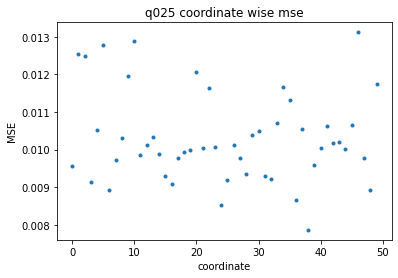

In [16]:
mse_q025 = np.mean((true_q025 - pred_q025[:10000,:])**2, 0)
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()

In [17]:
np.mean(mse_q025)

0.010296293457708362

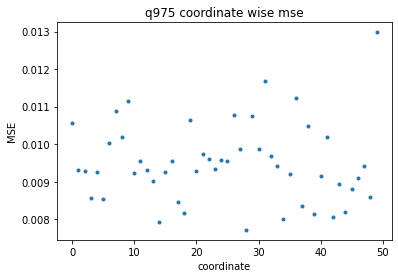

In [18]:
pred_q975 = predict(md_q975, Y_test_normalized)
mse_q975 = np.mean((true_q975 - pred_q975[:10000,:])**2, 0)
plt.plot(mse_q975,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q975 coordinate wise mse')
plt.show()

In [19]:
np.mean(mse_q975)

0.009492258300002799

In [20]:
md_mean = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
md_mean.load_state_dict(torch.load('./model/p50_mean_week10.pt'))
pred_mean = predict(md_mean, Y_test_normalized)

RuntimeError: CUDA out of memory. Tried to allocate 3.82 GiB (GPU 0; 8.00 GiB total capacity; 4.01 GiB already allocated; 55.57 MiB free; 5.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

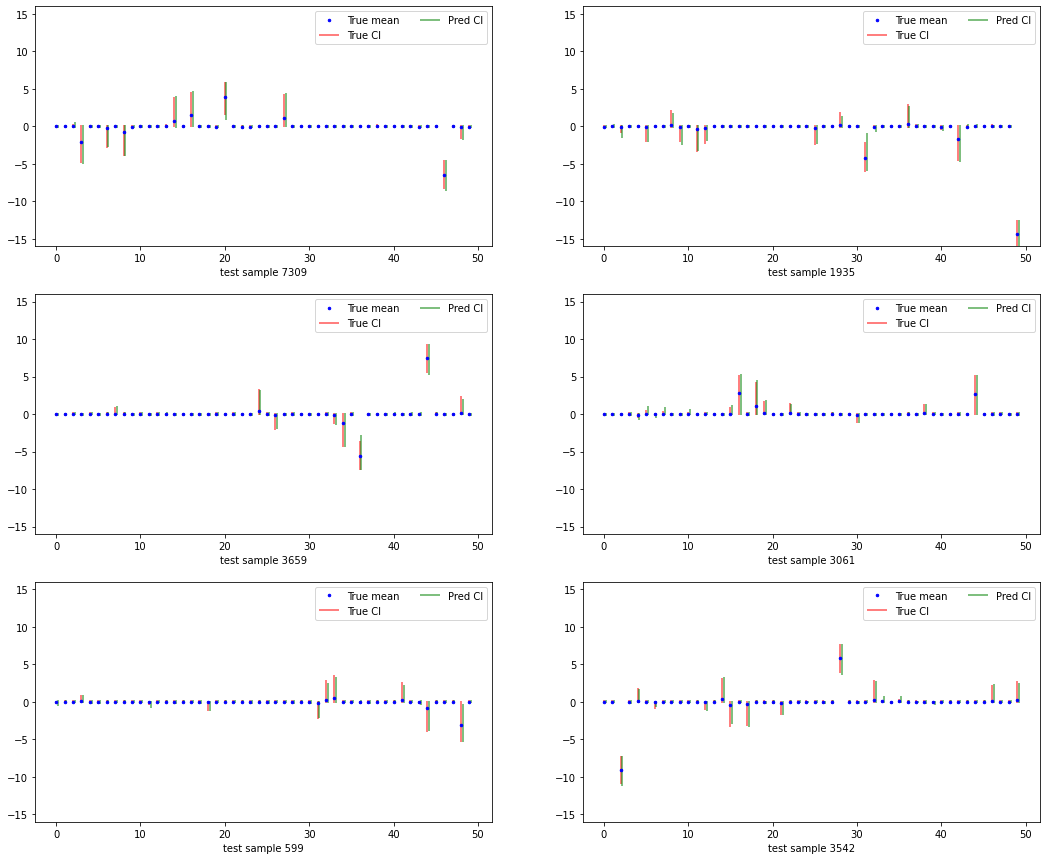

In [25]:
subset = np.where(np.abs(beta_test[:10000,:])>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    # plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
    plt.xlabel(f'test sample {idx}')
# plt.savefig('C:/Users/97255/OneDrive/Desktop/Bayesian Inference using DL/s2048_test_figures/test_10.png')
plt.show()

# p=200

In [2]:
train_losses_q025 = np.load('./results/train_losses_p200_q25_exp101.npy')
val_losses_q025 = np.load('./results/val_losses_p200_q25_exp101.npy')  
coordinate_loss_q025 = np.load('./results/coordinate_loss_p200_q25_exp101.npy')
# train_losses_q975 = np.load('./results/train_losses_p200_q975_exp4.npy')
# val_losses_q975 = np.load('./results/val_losses_p200_q975_exp4.npy')  
# coordinate_loss_q975 = np.load('./results/coordinate_loss_p200_q975_exp4.npy')

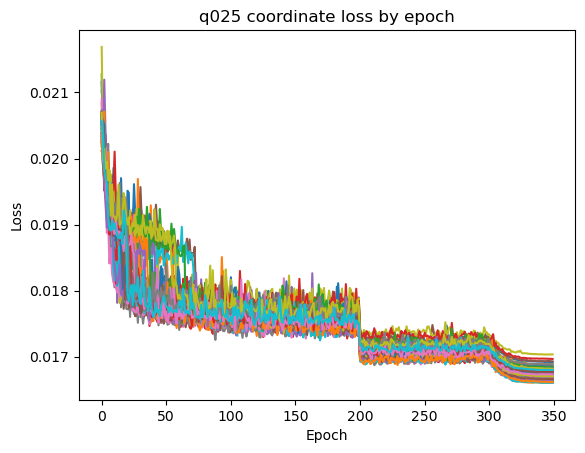

In [3]:
plt.plot(coordinate_loss_q025)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q025 coordinate loss by epoch")
plt.show()

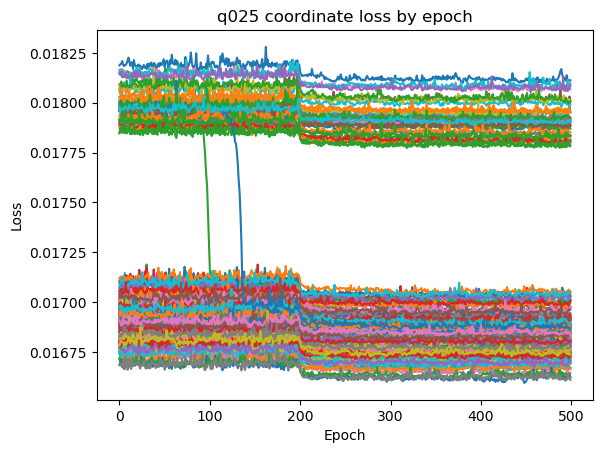

In [6]:
plt.plot(coordinate_loss_q025[1000:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q025 coordinate loss by epoch")
plt.show()

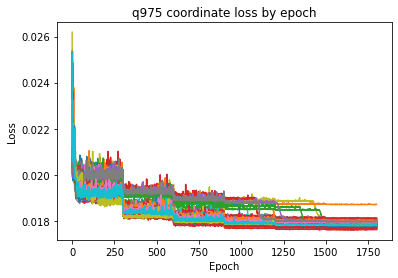

In [17]:
plt.plot(coordinate_loss_q975)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("q975 coordinate loss by epoch")
plt.show()

In [4]:
p = 200
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)
rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(5000)

In [13]:
'''
The posterior is also a Gaussian mixture of two components. The posterior mean is easy to compute. However, the 
quantile doesn't have close form solution. Use fsolve in scipy.optimize to solve equations for quantile.
'''
def computeNormalStats(sigma, sigma0, sigma1, Y):
    tau = 1 / sigma**2
    tau0 = 1 / sigma0**2
    tau1 = 1 / sigma1**2
    tau0_ = tau0 + tau 
    tau1_ = tau1 + tau 
    theta_ = theta / (theta + (1-theta) * np.sqrt(tau1_*tau0/(tau0_*tau1)) \
        * np.exp(-0.5 * tau**2 * (tau0_-tau1_) / (tau0_*tau1_) * Y**2))
    mu1 = tau / tau1_ * Y 
    mu0 = tau / tau0_ * Y 
    true_mean = theta_ * mu1 + (1-theta_) * mu0
    # Use different initial values according to Y to avoid solver failure.
    if np.abs(Y) > 4:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, Y)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, Y)
    else:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, 0)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, 0)        
    return true_mean, q025, q975

In [15]:
'''
Only the first 10,000 test samples are used for comparison. 
'''
true_mean = np.zeros((5000, p))
true_q025 = np.zeros((5000, p))
true_q975 = np.zeros((5000, p))

for i in tqdm(range(5000)):
    for j in range(p):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

100%|██████████| 5000/5000 [30:06<00:00,  2.77it/s]


In [16]:
np.save("./data/gs_p200_q025", true_q025)
np.save("./data/gs_p200_q975", true_q975)
np.save("./data/gs_p200_mean", true_mean)

In [5]:
true_q025 = np.load("./data/gs_p200_q025.npy")
true_q975 = np.load("./data/gs_p200_q975.npy")

In [6]:
mean = np.load("./results/mean_p200_q25_exp6.npy")
std = np.load("./results/std_p200_q25_exp6.npy")

In [7]:
Y_test_normalized = (Y_test - mean) / std 

In [8]:
def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

In [21]:
md_q025 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device) 
md_q025.load_state_dict(torch.load("./model/p200_q25_exp6.pt"))

<All keys matched successfully>

In [9]:
md_q025_s1 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q025_s2 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q025_s3 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q025_s4 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q975_s1 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q975_s2 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q975_s3 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)
md_q975_s4 = MLP_variant(200, 50, [512, 512], 'leakyrelu').to(device)

In [10]:
md_q025_s1.load_state_dict(torch.load("./model/p200_q25_exp101.pt"))
md_q025_s2.load_state_dict(torch.load("./model/p200_q25_exp102.pt"))
md_q025_s3.load_state_dict(torch.load("./model/p200_q25_exp103.pt"))
md_q025_s4.load_state_dict(torch.load("./model/p200_q25_exp104.pt"))
md_q975_s1.load_state_dict(torch.load("./model/p200_q975_exp101.pt"))
md_q975_s2.load_state_dict(torch.load("./model/p200_q975_exp102.pt"))
md_q975_s3.load_state_dict(torch.load("./model/p200_q975_exp103.pt"))
md_q975_s4.load_state_dict(torch.load("./model/p200_q975_exp104.pt"))

<All keys matched successfully>

In [11]:
pred_q025_s1 = predict(md_q025_s1, Y_test_normalized)
pred_q025_s2 = predict(md_q025_s2, Y_test_normalized)
pred_q025_s3 = predict(md_q025_s3, Y_test_normalized)
pred_q025_s4 = predict(md_q025_s4, Y_test_normalized)
pred_q975_s1 = predict(md_q975_s1, Y_test_normalized)
pred_q975_s2 = predict(md_q975_s2, Y_test_normalized)
pred_q975_s3 = predict(md_q975_s3, Y_test_normalized)
pred_q975_s4 = predict(md_q975_s4, Y_test_normalized)
pred_q025 = np.concatenate((pred_q025_s1, pred_q025_s2, pred_q025_s3, pred_q025_s4), axis=1)
pred_q975 = np.concatenate((pred_q975_s1, pred_q975_s2, pred_q975_s3, pred_q975_s4), axis=1)

In [22]:
pred_q025 = predict(md_q025, Y_test_normalized)
q025_loss = np.mean(np.maximum(0.025*(beta_test-pred_q025),0.975*(pred_q025-beta_test)), 0)
q025_loss

array([0.01804421, 0.01660971, 0.01489232, 0.0186069 , 0.01722382,
       0.01973929, 0.01631211, 0.01760397, 0.0166047 , 0.01738985,
       0.01870622, 0.01792413, 0.01606734, 0.01750861, 0.01705983,
       0.0178664 , 0.01800838, 0.01544166, 0.01752015, 0.01780036,
       0.01896953, 0.01656223, 0.01634282, 0.01456485, 0.01791265,
       0.01776875, 0.01789345, 0.01748177, 0.01696143, 0.01700963,
       0.01555513, 0.01644463, 0.01822283, 0.0151311 , 0.01835449,
       0.0166779 , 0.01778031, 0.01952616, 0.01995483, 0.01690465,
       0.01526577, 0.01738915, 0.01405798, 0.01694147, 0.01571389,
       0.01909891, 0.02035216, 0.01410866, 0.018454  , 0.01483622,
       0.01653707, 0.01602584, 0.01634598, 0.02010926, 0.01545105,
       0.01719732, 0.01714126, 0.01391399, 0.01508043, 0.02006211,
       0.01669403, 0.01424527, 0.0152733 , 0.01734832, 0.01686883,
       0.01748722, 0.01504163, 0.01862205, 0.01890782, 0.01749985,
       0.01697797, 0.01691698, 0.01683228, 0.01823355, 0.01496

In [18]:
coordinate_loss_q025.shape 

(1000, 200)

In [17]:
mse_q025 = np.mean((pred_q025 - true_q025)**2, 0)
mse_q975 = np.mean((pred_q975 - true_q975)**2, 0)

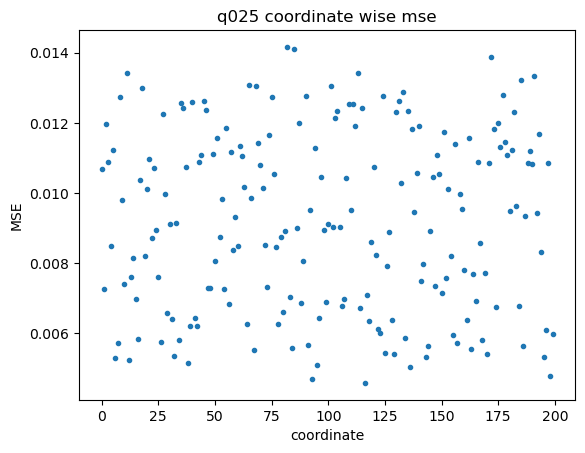

In [18]:
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()

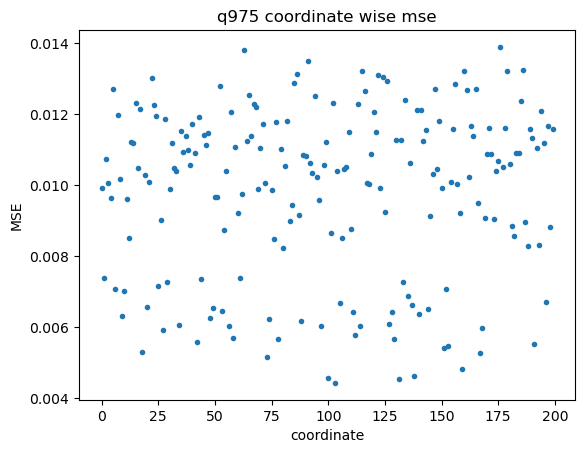

In [19]:
plt.plot(mse_q975,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q975 coordinate wise mse')
plt.show()

In [16]:
mse_q025.mean()

0.009188969514638929

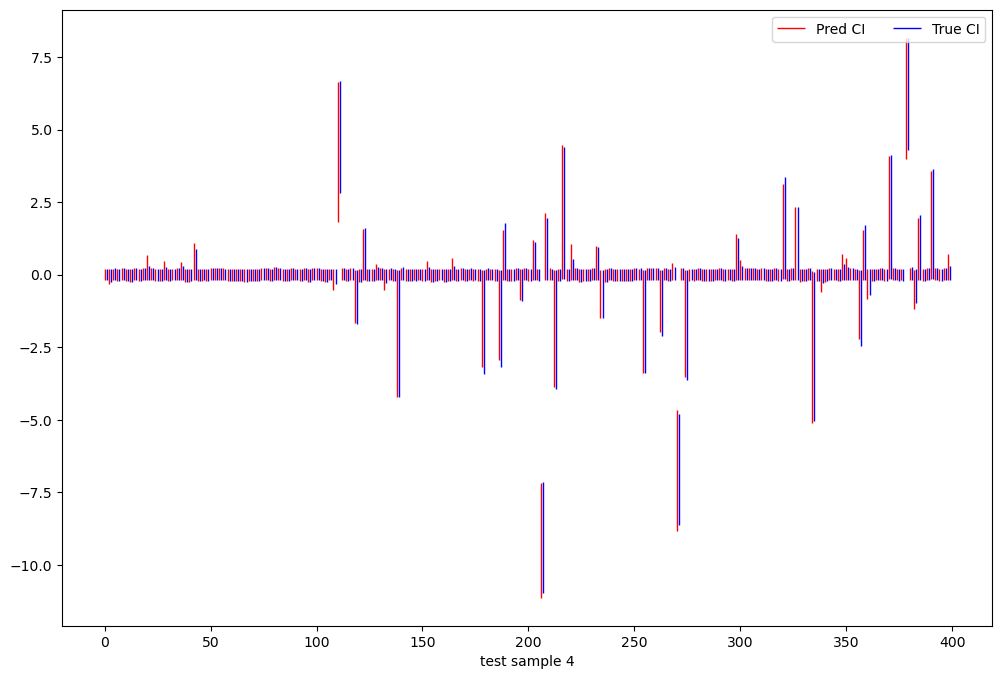

In [34]:
test_id = 4
plt.figure(figsize=(12, 8))
plt.vlines(np.arange(p)*2, pred_q025[test_id], pred_q975[test_id], color='red', alpha=1, lw=1)
plt.vlines(np.arange(p)*2+1, true_q025[test_id], true_q975[test_id], color='blue', alpha=1, lw=1)
plt.legend(["Pred CI", 'True CI'], ncol=2)
plt.xlabel(f'test sample {test_id}')
plt.show()

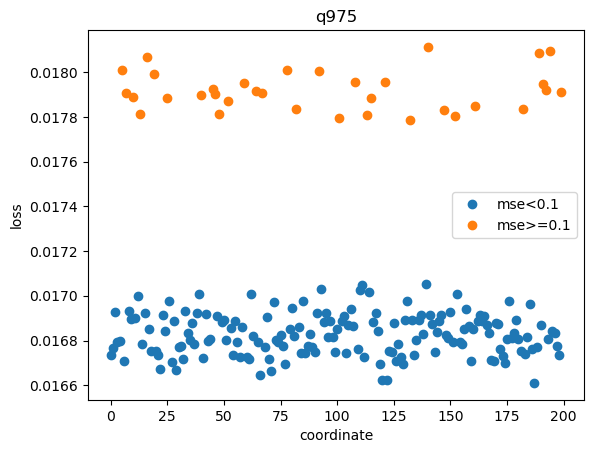

In [24]:
plt.plot(np.where(mse_q025<0.1)[0].reshape(-1), coordinate_loss_q025[-1,np.where(mse_q025<0.1)].reshape(-1), 'o')
plt.plot(np.where(mse_q025>=0.1)[0].reshape(-1), coordinate_loss_q025[-1, np.where(mse_q025>=0.1)].reshape(-1), 'o')
plt.legend(['mse<0.1', 'mse>=0.1'])
plt.ylabel('loss')
plt.xlabel('coordinate')
plt.title('q975')
plt.show()

In [40]:
import torch 
import torch.nn as nn

In [42]:
a = torch.arange(10)
b = a[::3]

In [49]:
perm = torch.randperm(a.size(0))
idx = perm[:3]
samples = a[idx]

In [ ]:
class MLP_variant(nn.Module):
    def __init__(self, N, p, num_nodes, ac_func='relu', dropout=0):
        super(MLP_variant, self).__init__()
        fc = []
        last_node = N
        for node in num_nodes:
            fc.append(nn.Linear(last_node, node))
            last_node = node 
        self.fc_final = nn.Linear(last_node, p)
        self.fc = nn.ModuleList(fc)
        assert ac_func in ('relu', 'tanh', 'leakyrelu', 'softplus', 'softsign', 'selu', 'elu')
        if ac_func == 'relu':
            self.activation = nn.ReLU()
        elif ac_func == 'tanh':
            self.activation = nn.Tanh()
        elif ac_func == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif ac_func == 'softplus':
            self.activation = nn.Softplus()
        elif ac_func == 'softsign':
            self.activation = nn.Softsign()
        elif ac_func == 'selu':
            self.activation = nn.SELU()
        elif ac_func == 'elu':
            self.activation = nn.ELU()
        self.mseloss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        for m in self.fc:
            x = self.dropout(self.activation(m(x)))
        x = self.fc_final(x)
        return x 
    
    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 

    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss 
    
    def get_quanloss_random(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        perm = torch.randperm(errs.size(1))
        idx = perm[:50]
        errs = errs[:,idx]
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss